# Notebook 6 - Property modeling with mol2vec
By Vincent Blay, November 2021

In this notebook, we explore the application of [mol2vec embeddings](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00616) to model different molecular properties. The embeddings are used as a drop-in replacement of conventional molecular descriptors. Given the relatively high dimensionality of mol2vec embeddings (300-D), we apply the heuristic feature selection approach that was also used in notebooks 4 and 5.

In [1]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo\\notebooks'

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

%run "./plotting.py"

In [3]:
%config InlineBackend.figure_format = 'retina'

We already have the molecules embedded using mol2vec:

In [4]:
df_mol2vec = pd.read_csv('../data/mol2vec_all.csv', index_col=0)
df_mol2vec.head()

,Smiles,dataset,mol2vec-000,mol2vec-001,mol2vec-002,mol2vec-003,mol2vec-004,mol2vec-005,mol2vec-006,mol2vec-007,...,mol2vec-290,mol2vec-291,mol2vec-292,mol2vec-293,mol2vec-294,mol2vec-295,mol2vec-296,mol2vec-297,mol2vec-298,mol2vec-299
0,C/C=C/C(C)(C)C,RON,-0.892758,2.260725,-0.885212,0.085897,2.098727,-1.027072,-4.708672,-0.178004,...,-2.932562,-0.508684,3.100115,-0.821230,-2.645380,-3.025425,-0.382884,-1.689788,-5.125613,-1.924297
1,C/C=C/CCC(C)C,RON,-0.678342,-0.238011,-1.003397,0.774230,2.981085,-0.551984,-5.090776,-0.281822,...,-1.851958,1.159234,2.734748,0.194709,-3.712619,-0.925730,-0.716665,-2.982629,-4.313823,-1.696794
2,O=C1CCCC1,RON,1.234810,-1.350805,-1.046149,1.105939,-0.766294,-0.839044,-1.632772,1.366373,...,0.061407,4.001074,-0.895604,-0.483040,-3.224171,-1.588557,-2.406893,-1.329926,-2.014662,0.257858
3,C1CCCC1,RON,1.247706,-1.549743,0.130658,1.204699,-0.932407,-0.460625,-1.557672,0.880275,...,0.405841,3.888128,-0.772358,-1.161128,-2.507605,-1.529295,-1.959982,-1.544674,-1.787258,-0.313531
4,C1CCCCC1,RON,1.497248,-1.859691,0.156789,1.445638,-1.118889,-0.552750,-1.869206,1.056330,...,0.487009,4.665753,-0.926829,-1.393353,-3.009126,-1.835154,-2.351978,-1.853608,-2.144710,-0.376238


## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [5]:
df = pd.read_csv("../data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


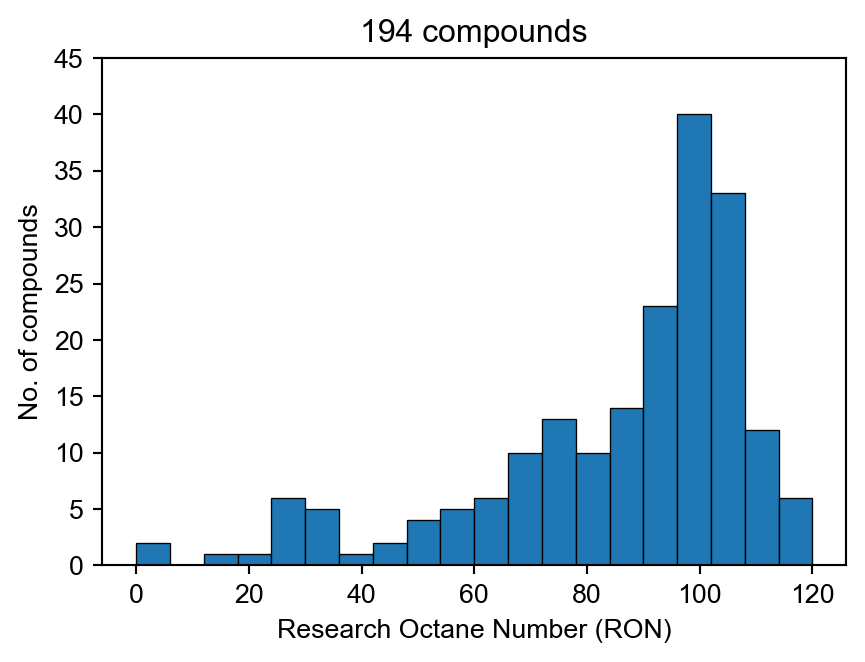

In [6]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

In [7]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='RON'].iloc[:,2:])
D.shape

(194, 300)

Let us split the data in training and validation sets:

In [8]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)

Now we want to select a subset of signatures that we will use to train the model.

In [9]:
%%time

regr = LinearRegression()

sfs = SequentialFeatureSelector(regr, n_features_to_select=15)
sfs.fit(D_train, y_train)

Wall time: 1min 29s


SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=15)

Now we use the selected descriptors to train a Support Vector Regressor (SVR) from the `sklearn` package.

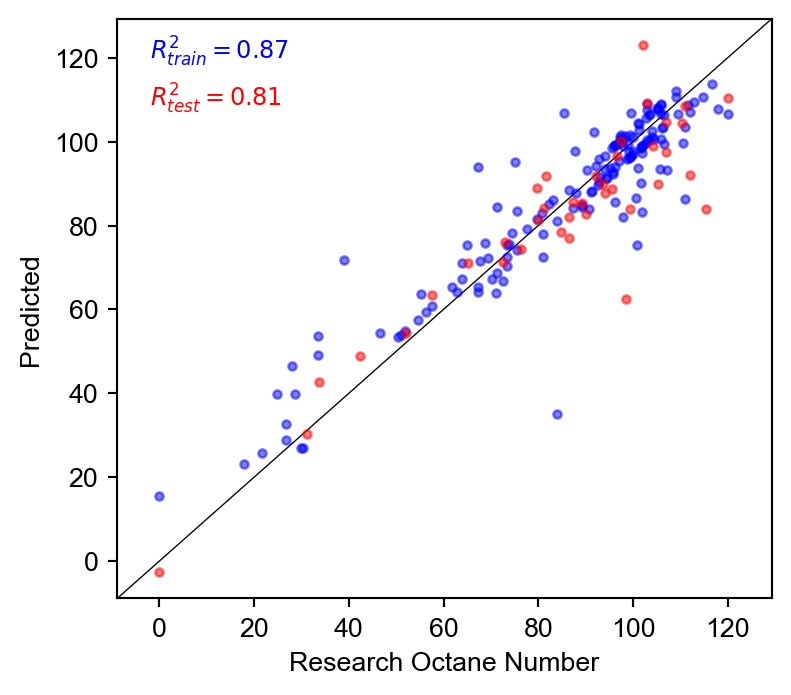

In [10]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=100, epsilon=3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Research Octane Number", savetitle='../results/mol2vec/RON_mol2vec.svg') 

## Cetane Number (CN)

In [11]:
df = pd.read_csv("../data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


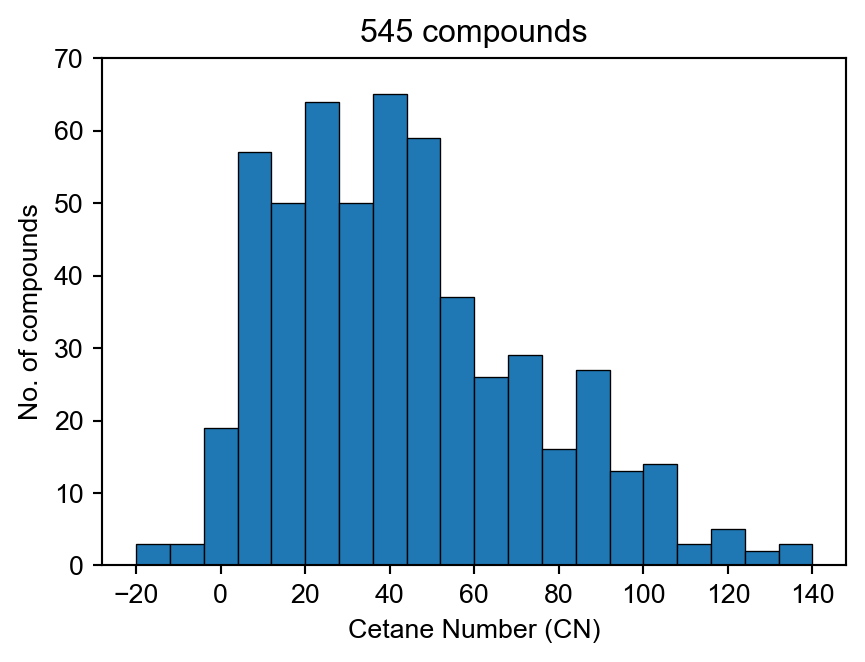

In [12]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

In [13]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='CN'].iloc[:,2:])
D.shape

(545, 300)

In [14]:
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)
sfs.fit(D_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=15)

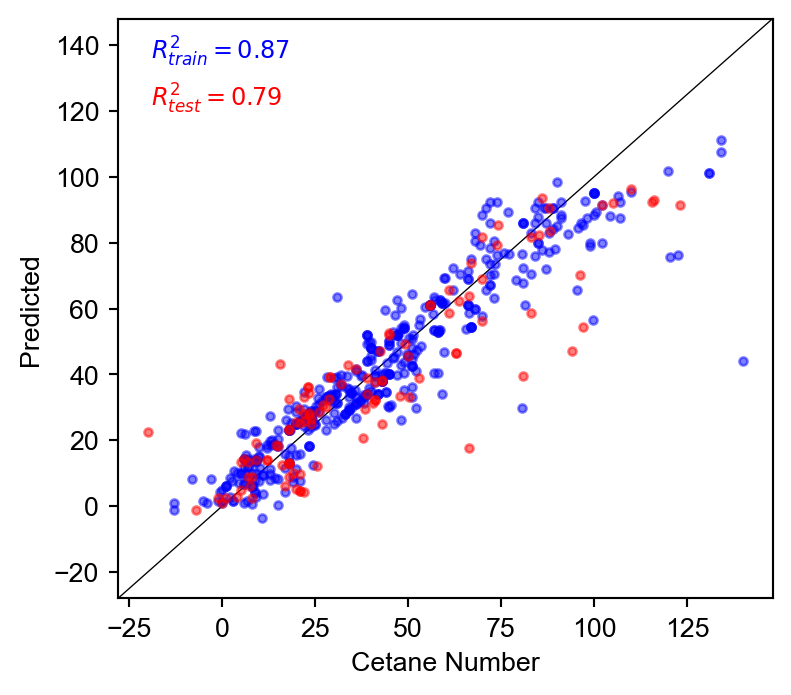

In [15]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Cetane Number",  savetitle='../results/mol2vec/CN_mol2vec.svg') 

## Yield Sooting Index

In [16]:
df = pd.read_csv("../data/data_YSI.csv")
smiles = df.Smiles
Y = df.YSI
print(len(smiles))

610


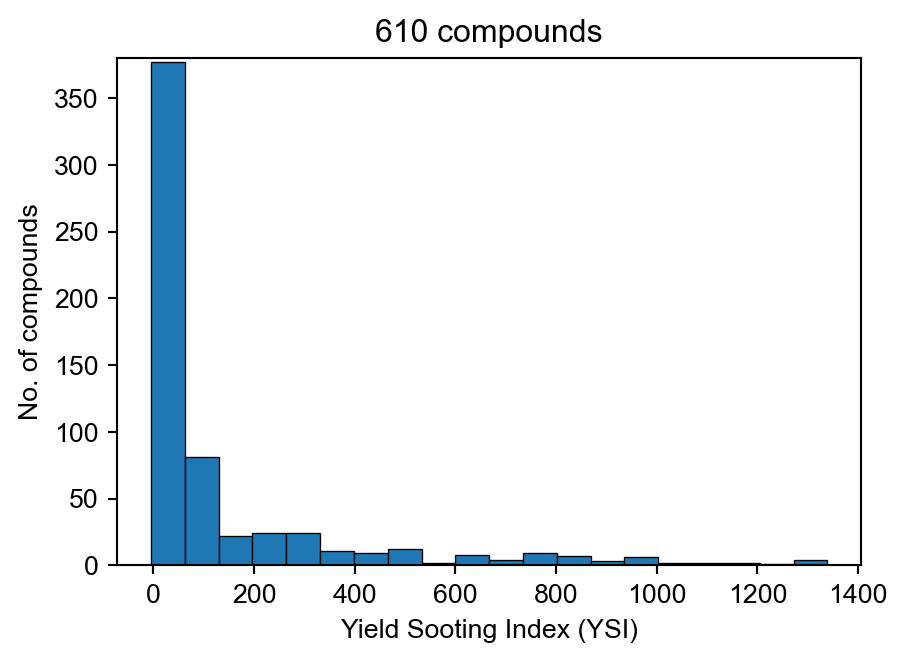

In [17]:
plot_histogram(Y, xlabel="Yield Sooting Index (YSI)")

In [18]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='YSI'].iloc[:,2:])
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)
sfs.fit(D_train, y_train)
print(D.shape)

(610, 300)


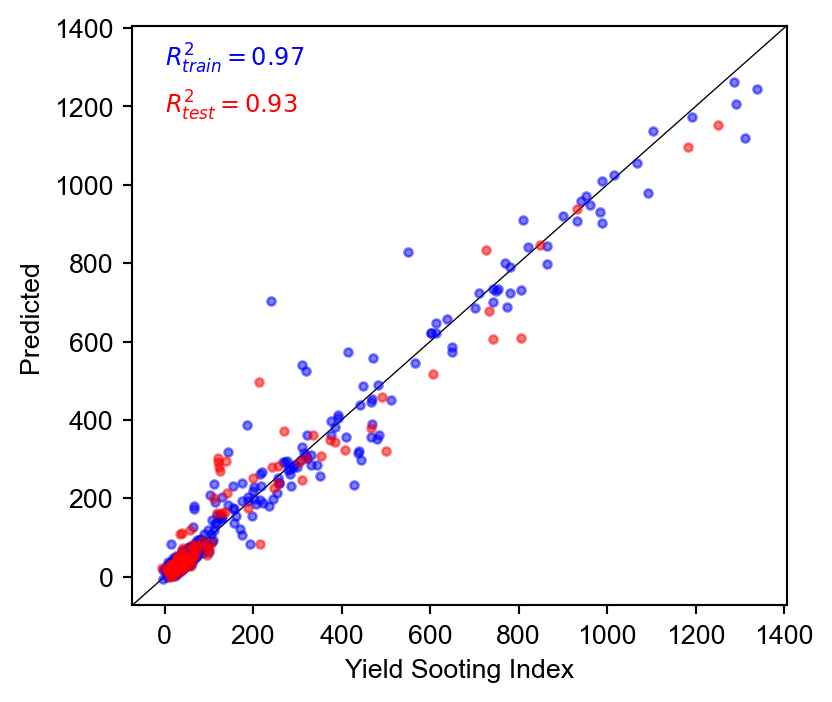

In [19]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Yield Sooting Index",  savetitle='../results/mol2vec/YSI_mol2vec.svg') 

##  Melting Point (MP)

In [20]:
df = pd.read_csv("../data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


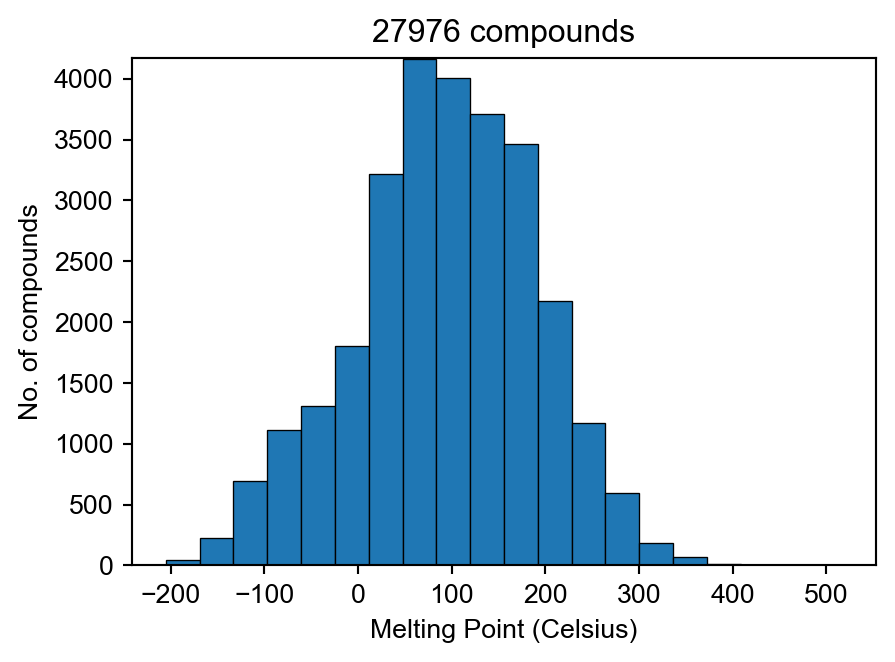

In [21]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [22]:
%%time

D = np.array(df_mol2vec[df_mol2vec['dataset']=='MP'].iloc[:,2:])
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)
sfs.fit(D_train, y_train)
print(D.shape)

(27976, 300)
Wall time: 6min 24s


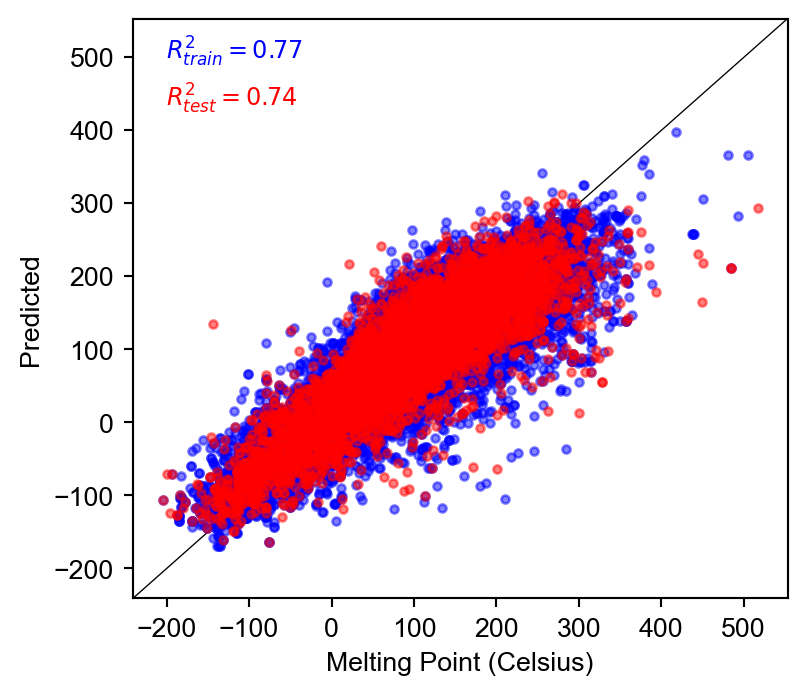

In [23]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Melting Point (Celsius)",  savetitle='../results/mol2vec/MP_mol2vec.svg') 

## Flash Point (FP)

In [24]:
df = pd.read_csv("../data/data_FP.csv")
smiles = df.Smiles
Y = df.FP
print(len(smiles))

631


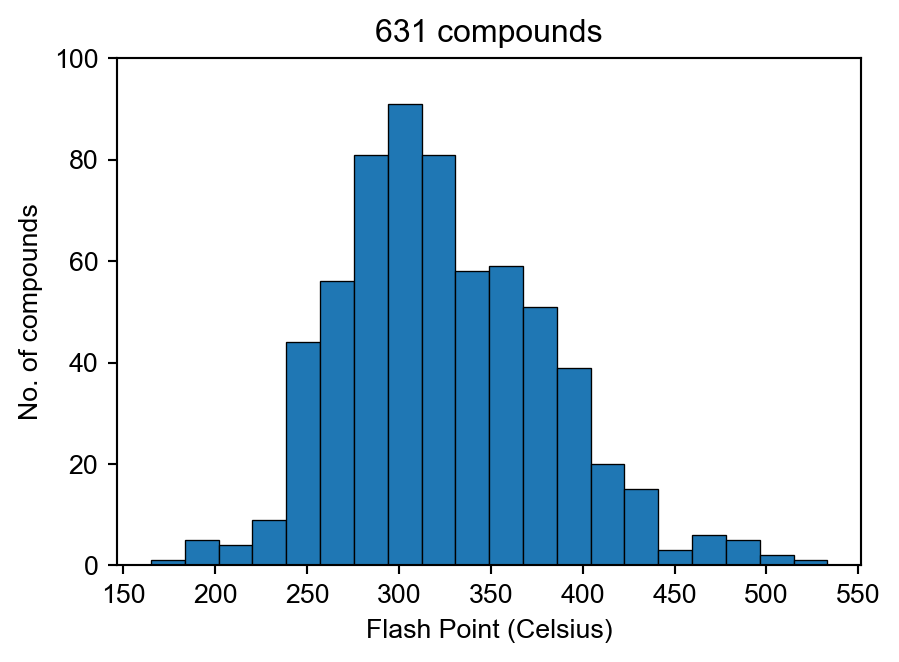

In [25]:
plot_histogram(Y, xlabel="Flash Point (Celsius)")

In [26]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='FP'].iloc[:,2:])
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)
sfs.fit(D_train, y_train)
print(D.shape)

(631, 300)


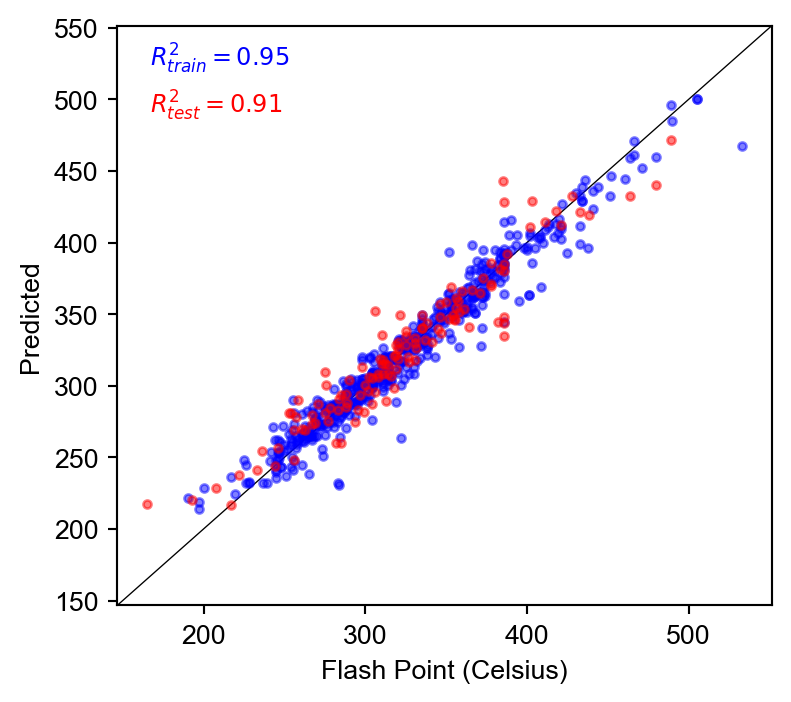

In [27]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=300, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Flash Point (Celsius)",  savetitle='../results/mol2vec/FP_mol2vec.svg') 

## Histamine receptor pKi

In [28]:
df = pd.read_csv("../data/data_H1.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1214


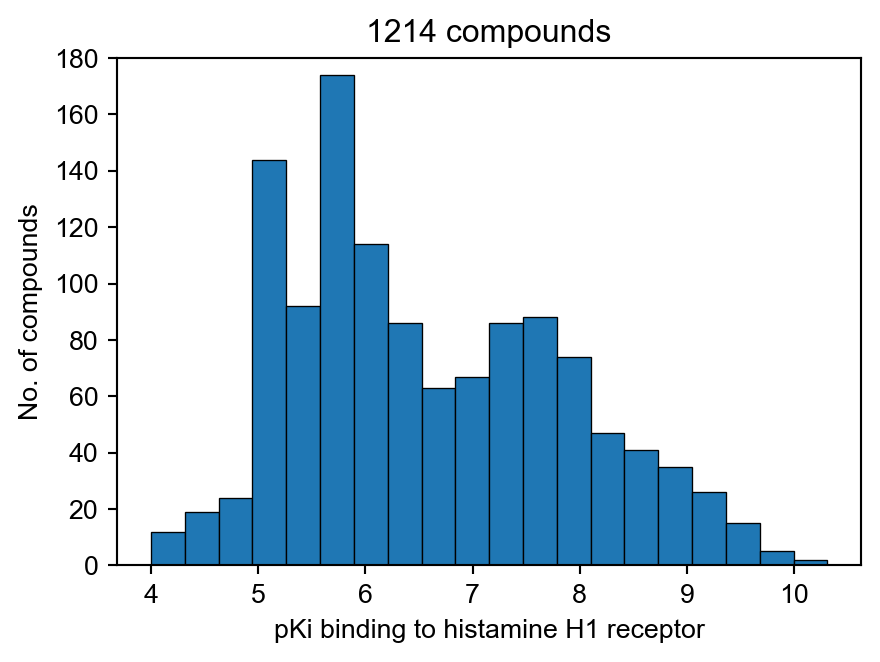

In [29]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [30]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='H1'].iloc[:,2:])
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)
sfs.fit(D_train, y_train)
print(D.shape)

(1214, 300)


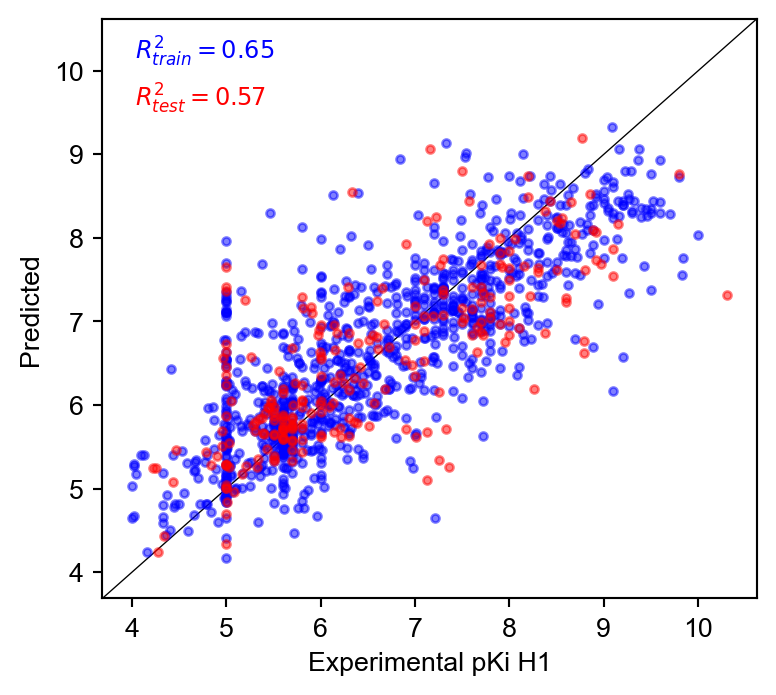

In [31]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=10, epsilon=.1)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel='Experimental pKi H1',  savetitle='../results/mol2vec/H1_mol2vec.svg') 

## Muscarinic receptor pKi

In [32]:
df = pd.read_csv("../data/data_M2.csv")
Y = df.pKi
smiles = df.Smiles
print(len(smiles))

1145


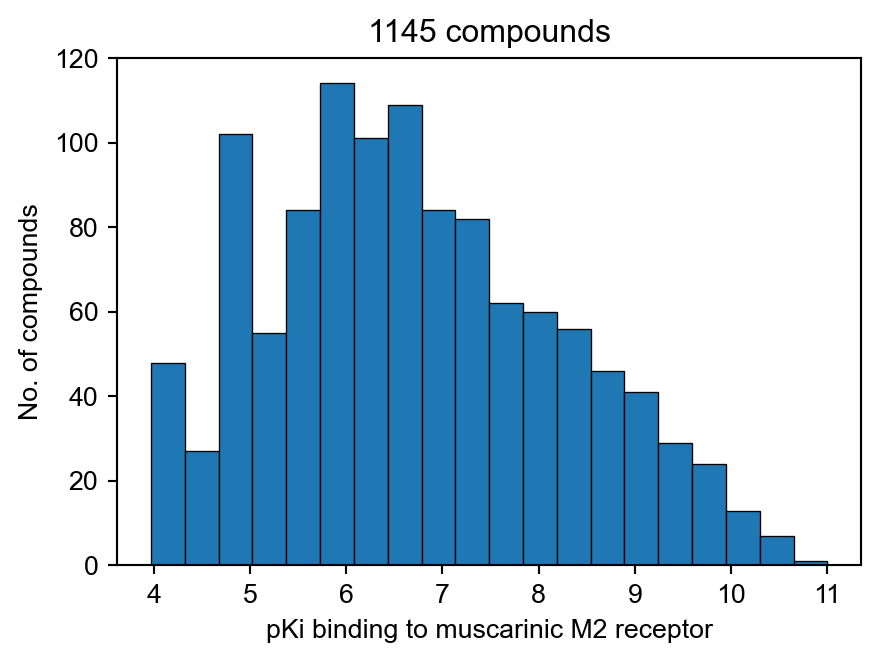

In [33]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [34]:
D = np.array(df_mol2vec[df_mol2vec['dataset']=='M2'].iloc[:,2:])
D_train, D_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 42)
sfs.fit(D_train, y_train)
print(D.shape)

(1145, 300)


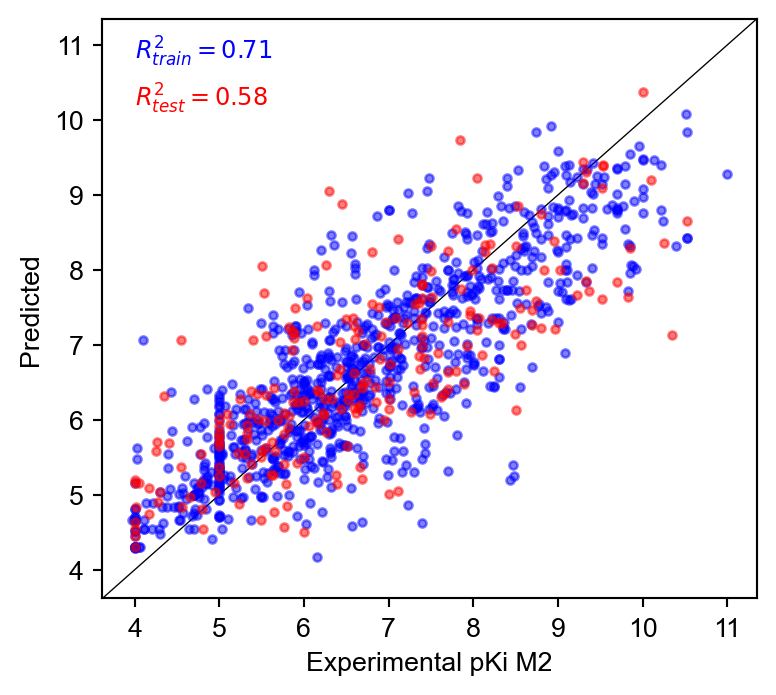

In [35]:
X_train = sfs.transform(D_train)
X_test = sfs.transform(D_test)

regr = SVR(kernel='rbf', C=10, epsilon=.3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Experimental pKi M2",  savetitle='../results/mol2vec/M2_mol2vec.svg') 